In [124]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from gradient_delay import *
from peak_picking import *

# CEOAE data loading
mat_CEOAE = scipy.io.loadmat("data/ceoae2/ceoae50g130R29rs20.mat")

fs = mat_CEOAE['fs'].flatten()  # sample rate
CEOAE = mat_CEOAE['click50'].flatten()  # CEOAE wave
time_axis = np.arange(0, np.size(CEOAE)/fs, 1/fs)

# we cut off spectrum because our reference is only at isolated frequencies
spectrum = np.fft.fft(CEOAE)
fx = np.arange(len(spectrum))*fs/len(spectrum)
spectrum = spectrum[(fx >= 1000) & (fx <= 3200)]
fx = fx[(fx >= 1000) & (fx <= 3200)]

log_spectrum = 20*np.log10(np.abs(spectrum))
grad_delay = calcDelay(fx, spectrum)

# peak picking
maximas_CEOAE = findLocalMaxima(np.real(20*np.log10(spectrum)))
shift = 1  # 3 points around all peaks (the peak is included)
ext_maximas_CEOAE = peakNeighbours(maximas_CEOAE, shift, np.size(fx))


ISOINTENSITY (REFERENCE)

In [125]:
from isoint import *

ISOINT_start, ISOINT_stop, ISOINT_step = 1000, 3200, 200

freq_ISOINT_list = []
GD_ISOINT_list = []
max_idx_ISOINT_list = []

for i in range(ISOINT_start, ISOINT_stop + 1, ISOINT_step):
    filename = f"data/isointFT/isoint_{i}Hz_Level_20dB_TM45130.mat"
    freq_ISOINT, group_delay_ISOINT, max_idx_ISOINT = processIsoInt(filename)

    freq_ISOINT_list.append(freq_ISOINT)
    GD_ISOINT_list.append(group_delay_ISOINT)
    max_idx_ISOINT_list.append(max_idx_ISOINT)


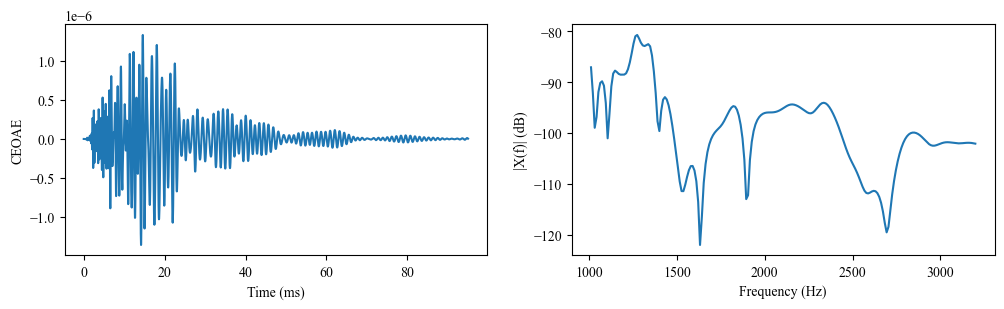

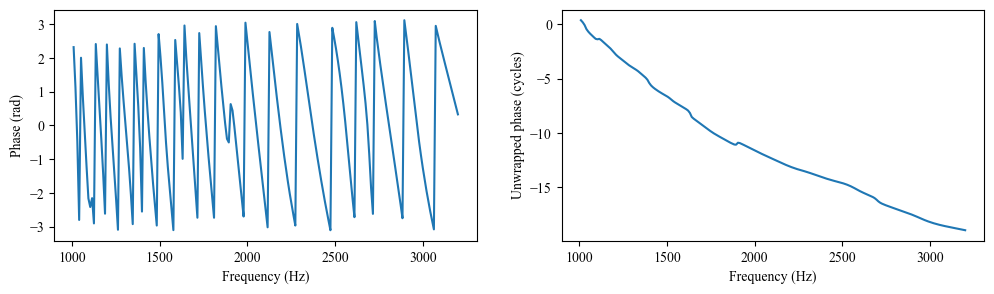

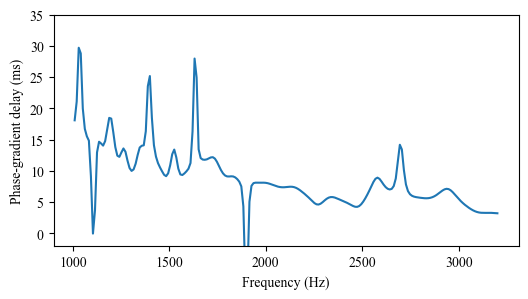

In [126]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2)
ax1.plot(1000*time_axis, CEOAE)
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("CEOAE")

ax2.plot(fx, log_spectrum)
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("|X(f)| (dB)")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
ax1.plot(fx, np.angle(spectrum))
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Phase (rad)")
ax2.plot(fx, np.unwrap(np.angle(spectrum))/(2*np.pi))
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Unwrapped phase (cycles)")

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(fx, 1000*grad_delay)
ax.set_ylim(-2, 35)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Phase-gradient delay (ms)")
plt.show()


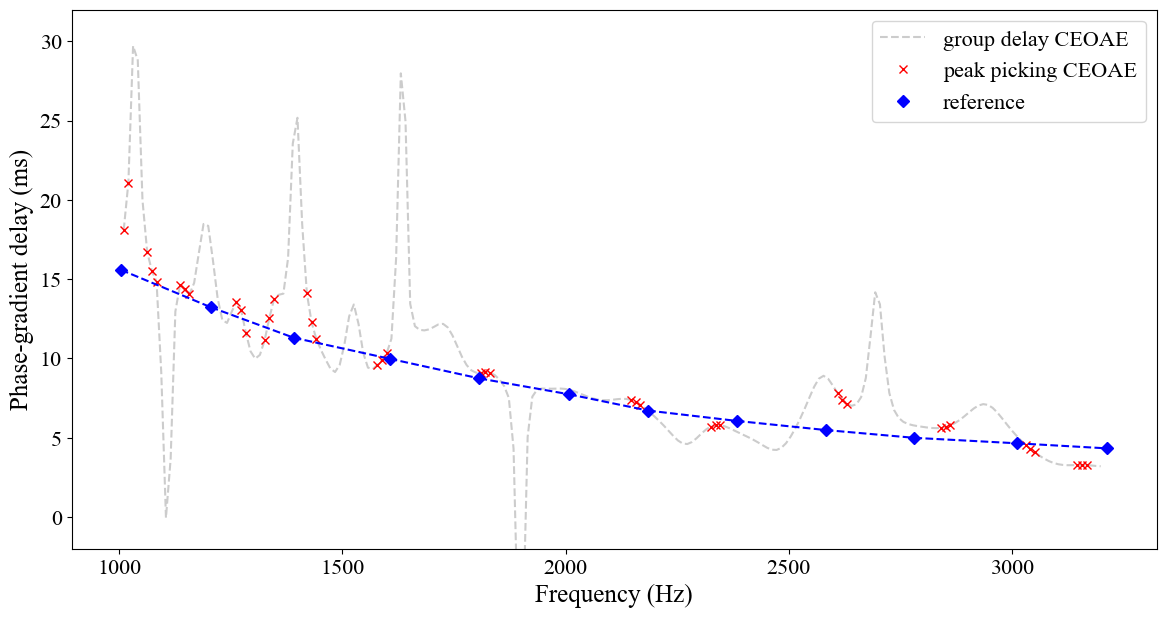

In [127]:
from matplotlib.ticker import FixedLocator, FixedFormatter

fig, ax = plt.subplots(figsize=(14, 7))

# multiplying by 1000 because of the transfer to miliseconds
ax.plot(fx, 1000*grad_delay, '0.8',
        linestyle='--', label='group delay CEOAE')
ax.plot(fx[ext_maximas_CEOAE], 1000*grad_delay[ext_maximas_CEOAE],
        "rx", label='peak picking CEOAE')

# reference values
for i, freq_ISOINT in enumerate(freq_ISOINT_list):
    max_idx = max_idx_ISOINT_list[i]
    grad_delay_ISOINT = GD_ISOINT_list[i]
    ax.plot(freq_ISOINT[max_idx], 1000*grad_delay_ISOINT[max_idx],
            "bD", label='reference' if i == 0 else None)
    if i > 0:  # connect points starting from the second point
        ax.plot([freq_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]], freq_ISOINT[max_idx]],
                [1000*GD_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]],
                    1000*grad_delay_ISOINT[max_idx]],
                "b--")

ax.set_ylim([-2, 32])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Frequency (Hz)', fontdict={"fontsize": 18})
ax.set_ylabel('Phase-gradient delay (ms)', fontdict={"fontsize": 18})
ax.legend(fontsize=16)

plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
